In [1]:
import pandas as pd
import seaborn as sns

Make movies with scores about 60% type 1, aka Fresh.

In [2]:
critic_table = pd.read_pickle('critic_table.pkl')
critic_table['critic'] = (critic_table.critic>60).astype(int)

Add a feature num_genres to count how many genres a movie has, get dummies for categorical variables and create a new feature "starpower" as a measure of the reliance of fame in marketing.

In [3]:
num_genres = critic_table.loc[:,'Action':].sum(axis=1)
num_genres = num_genres.rename('num_genres')
critic_table = critic_table.join(num_genres)

critic_table = pd.get_dummies(critic_table,columns = ['rating','decade','aspect_ratio','language','country'],drop_first=True)
critic_table = critic_table.drop(['rating','year','genre','title'],axis=1,errors='ignore')

critic_table['starpower'] = critic_table.post_face * (critic_table.actor_1_fb+critic_table.actor_2_fb+critic_table.actor_3_fb)

### Discriminative Features

Below we see a lack of linear separability in the continuous features, but I still choose to keep them all for now.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


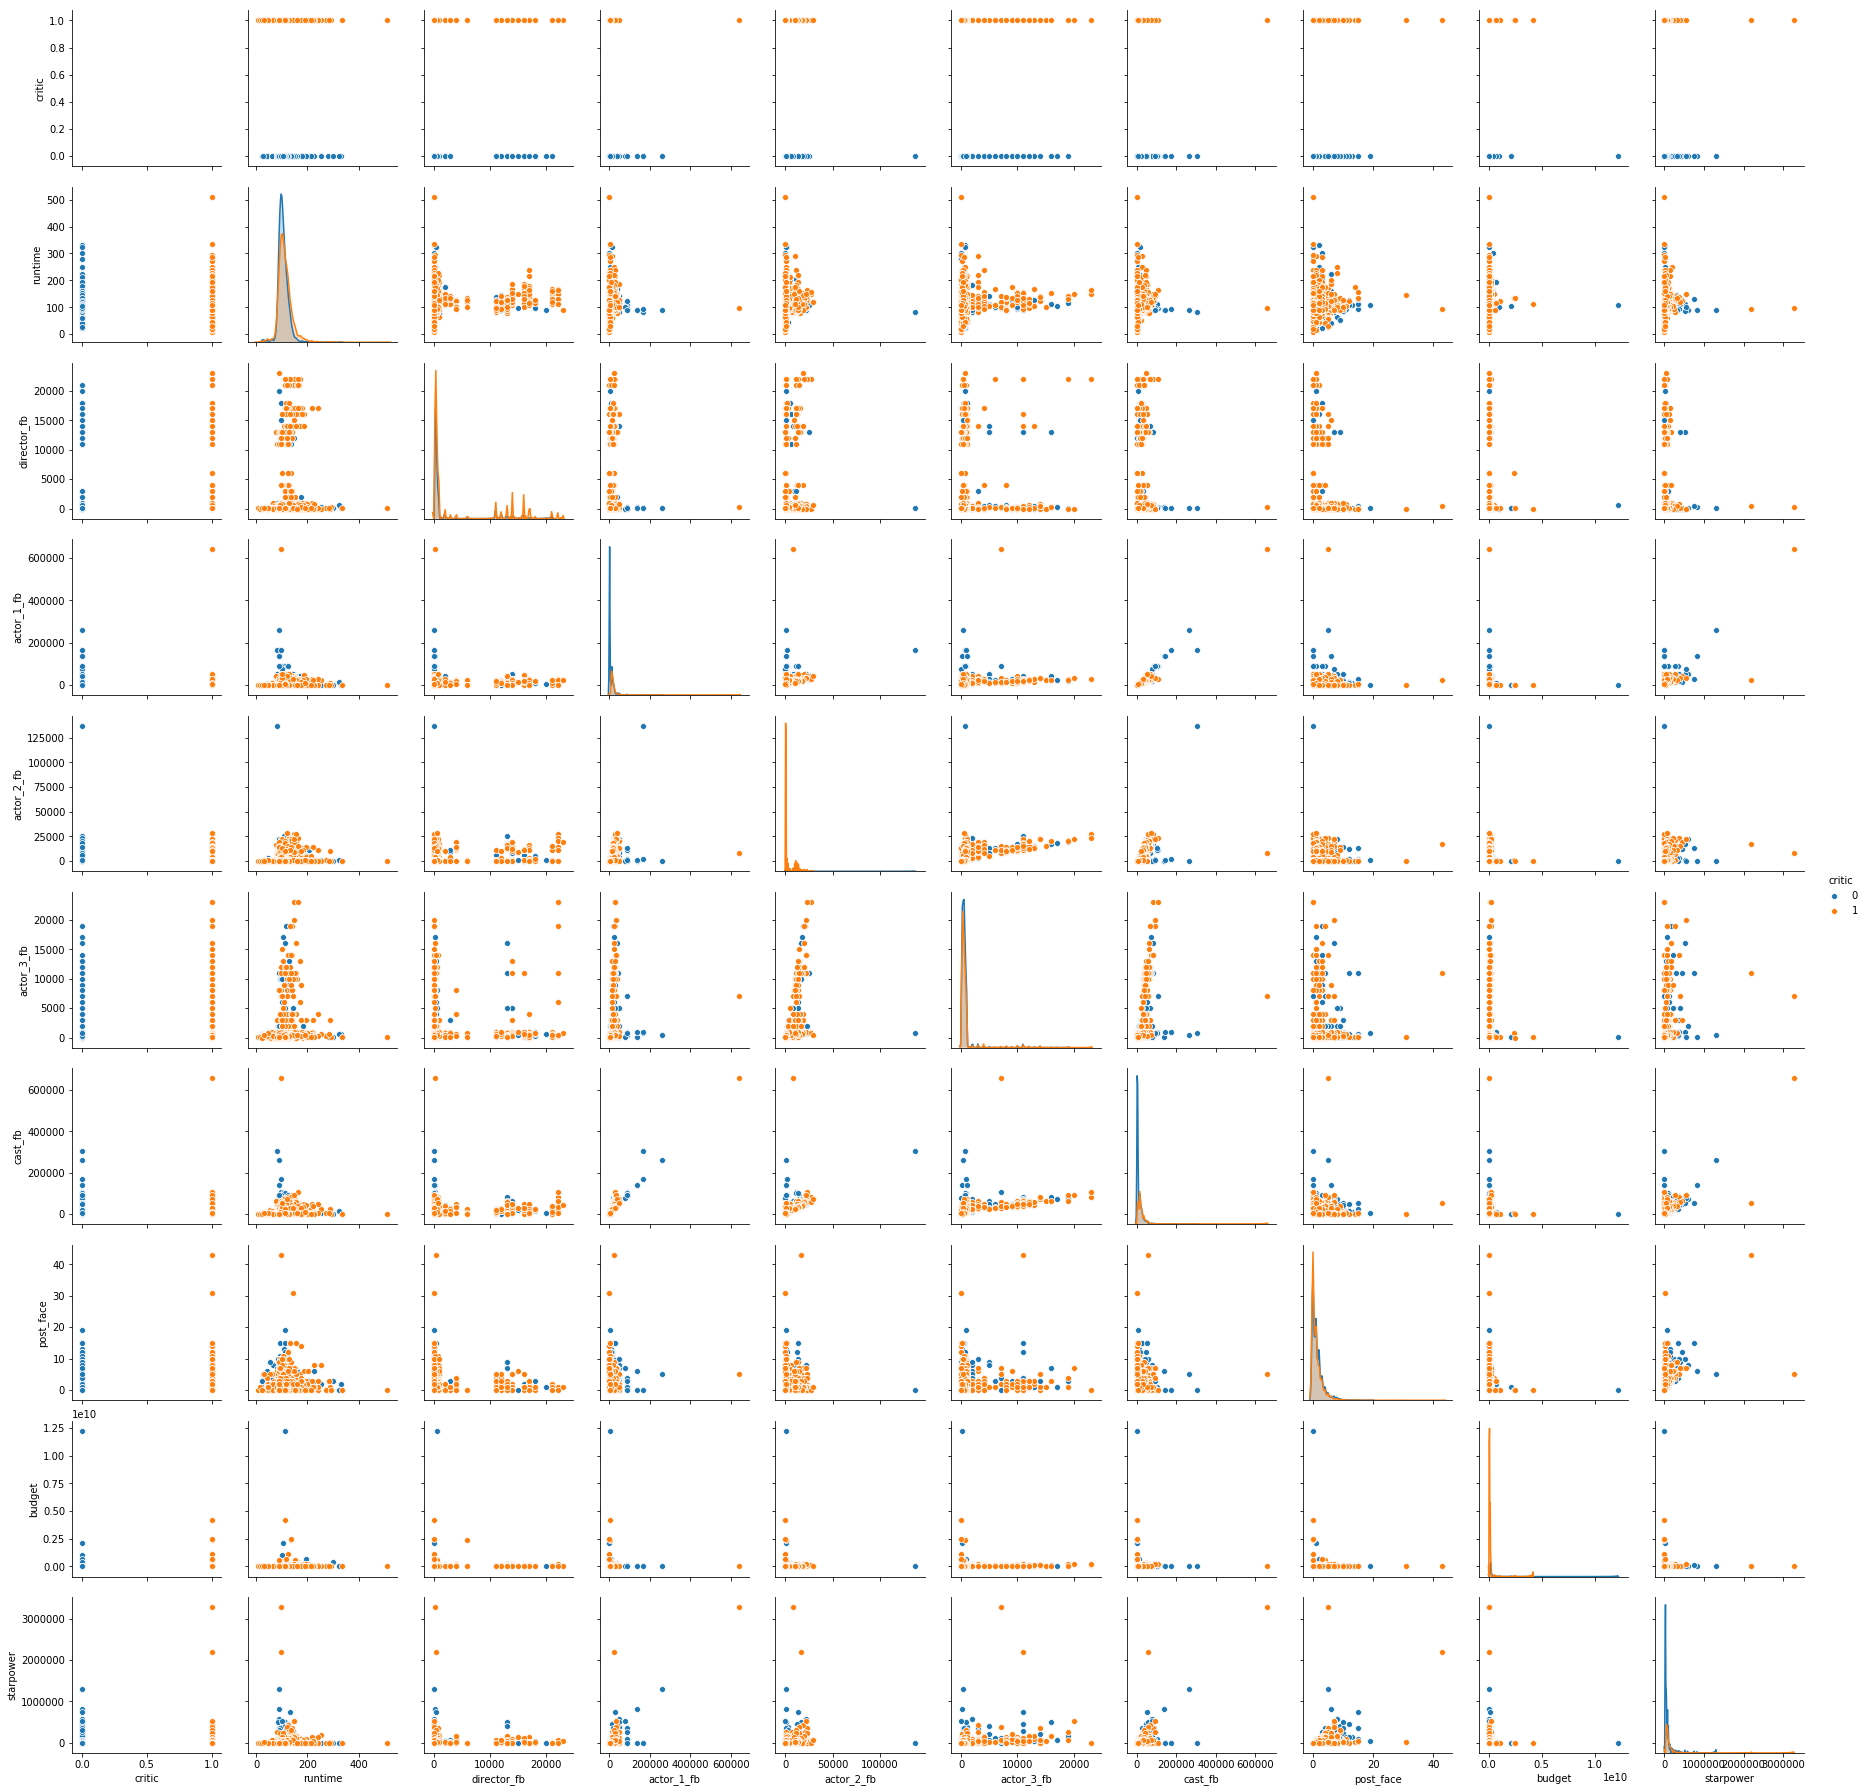

In [4]:
critic_num = critic_table.loc[:,['critic','runtime','director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'post_face', 'budget','starpower']]
sns.pairplot(critic_num,hue='critic')

For categorical features, drop those where only 40-60% of movies with that genre were liked. Less than that should be moderately to very disliked, more than that should be moderately to very liked.

In [5]:
critic_kat = critic_table.columns.difference(['critic','runtime','director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'post_face', 'budget','starpower'])

In [6]:
for cat in critic_kat :
    that_cat = critic_table[critic_table[cat]==1]
    total_cat = len(that_cat)
    liked = len(that_cat[that_cat.critic==1])
    percent_liked = liked/total_cat
    if percent_liked>.6 or percent_liked < .4 :
            print(cat)
            print(percent_liked)
    else :
        critic_table = critic_table.drop(cat,axis=1)

Action
0.33233233233233234
Biography
0.7148014440433214
Documentary
0.8365384615384616
Film-Noir
1.0
Game-Show
0.0
History
0.6774193548387096
Horror
0.33766233766233766
News
1.0
Short
0.6666666666666666
War
0.628140703517588
Western
0.6352941176470588
country_France
0.6111111111111112
country_UK
0.6486486486486487
decade_70s
0.7920792079207921
decade_80s
0.6612244897959184
decade_old
0.889763779527559
language_andre
0.7463235294117647
rating_PG-13
0.34966592427616927
rating_andre
0.6651376146788991


Here I drop poster faces as it has been used to create another variable and likely on its own does not tell us much.

In [7]:
critic_table = critic_table.drop('post_face',axis=1)

In [8]:
critic_table.columns

Index(['critic', 'runtime', 'director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'cast_fb', 'budget', 'Action', 'Biography', 'Documentary',
       'Film-Noir', 'Game-Show', 'History', 'Horror', 'News', 'Short', 'War',
       'Western', 'rating_PG-13', 'rating_andre', 'decade_70s', 'decade_80s',
       'decade_old', 'language_andre', 'country_France', 'country_UK',
       'starpower'],
      dtype='object')

### Class Imbalance

There is a slight imbalance, I'll play around with this in the next notebook.

In [9]:
critic_table.critic.value_counts()[1]/(critic_table.critic.value_counts()[1]+critic_table.critic.value_counts()[0])

0.476319350473613

Among categorical variables, I want to make sure that there is at least 100 samples for each; less than that is quite possibly not going to give us a trend but rather a fluke.

In [11]:
for kat in critic_table.columns :
    number_kat = len(critic_table[critic_table[kat]==1])
    if number_kat > 0 :
        if number_kat < 100 :
            critic_table = critic_table.drop(kat,axis=1)
        else :
            print(kat)
            print(number_kat)
            print(number_kat/len(critic_table))

critic
2112
0.476319350473613
Action
999
0.2253044654939107
Biography
277
0.06247180875056382
Documentary
104
0.02345511953089761
History
186
0.04194857916102842
Horror
462
0.10419485791610285
War
199
0.044880469102390616
rating_PG-13
1347
0.3037889039242219
rating_andre
436
0.09833107803337844
decade_70s
101
0.02277852954442941
decade_80s
245
0.05525484889490302
decade_old
127
0.02864230942715381
language_andre
272
0.06134415877311682
country_France
144
0.03247631935047361
country_UK
407
0.09179070816418583


### Collinearity

Here I drop highly collinear features, of which there was only really one.

In [17]:
critic_table = critic_table.drop('cast_fb',axis=1)

In [18]:
critic_table.corr()

,critic,runtime,director_fb,actor_1_fb,actor_2_fb,actor_3_fb,budget,Action,Biography,Documentary,...,War,rating_PG-13,rating_andre,decade_70s,decade_80s,decade_old,language_andre,country_France,country_UK,starpower
critic,1.000000,0.144881,0.125406,-0.010037,0.021373,0.014139,-0.019672,-0.155475,0.123260,0.111778,...,0.065895,-0.167514,0.124849,0.096525,0.089535,0.142151,0.138204,0.049446,0.109694,-0.003973
runtime,0.144881,1.000000,0.161993,0.088581,0.122038,0.112087,0.062528,0.074433,0.184473,-0.072674,...,0.193344,0.077078,-0.132640,0.073110,0.046875,0.099575,0.060087,0.009500,0.032422,0.032839
director_fb,0.125406,0.161993,1.000000,0.097000,0.115500,0.117587,0.018586,-0.001866,0.063548,-0.015143,...,0.023844,0.008248,-0.044972,0.072390,0.035615,0.005648,-0.036802,-0.025210,-0.048620,0.019717
actor_1_fb,-0.010037,0.088581,0.097000,1.000000,0.386435,0.245633,0.021372,0.064868,0.025107,-0.058595,...,-0.007090,0.073623,-0.105478,-0.028381,-0.036728,-0.064243,-0.082863,-0.028820,-0.018043,0.700817
actor_2_fb,0.021373,0.122038,0.115500,0.386435,1.000000,0.537934,0.038034,0.065715,0.023322,-0.052076,...,0.000350,0.078809,-0.105964,-0.030497,-0.052080,-0.058537,-0.093817,-0.034424,-0.030556,0.247582
actor_3_fb,0.014139,0.112087,0.117587,0.245633,0.537934,1.000000,0.040242,0.054965,-0.000973,-0.048917,...,-0.002830,0.110433,-0.089380,-0.026955,-0.044655,-0.048500,-0.086417,-0.019698,-0.029559,0.286115
budget,-0.019672,0.062528,0.018586,0.021372,0.038034,0.040242,1.000000,0.067407,-0.015956,-0.023148,...,0.014045,0.040199,-0.044116,-0.022441,-0.023722,-0.028726,0.097321,-0.009941,-0.020573,0.007822
Action,-0.155475,0.074433,-0.001866,0.064868,0.065715,0.054965,0.067407,1.000000,-0.099059,-0.072877,...,0.042146,0.127376,-0.082005,-0.002734,0.042057,-0.040823,-0.025382,-0.004397,-0.020003,0.021945
Biography,0.123260,0.184473,0.063548,0.025107,0.023322,-0.000973,-0.015956,-0.099059,1.000000,0.033884,...,0.079075,0.005776,-0.025781,-0.020673,0.010990,0.005956,-0.003854,0.021050,0.098680,-0.005743
Documentary,0.111778,-0.072674,-0.015143,-0.058595,-0.052076,-0.048917,-0.023148,-0.072877,0.033884,1.000000,...,0.031183,-0.050529,0.159014,-0.003685,-0.030958,-0.026613,0.022482,-0.003174,-0.002819,-0.020791


### Feature General Info
There are 7 continuous variables and 11 categorical variables (exluding the decade variables).

In [20]:
critic_table.columns

Index(['critic', 'runtime', 'director_fb', 'actor_1_fb', 'actor_2_fb',
       'actor_3_fb', 'budget', 'Action', 'Biography', 'Documentary', 'History',
       'Horror', 'War', 'rating_PG-13', 'rating_andre', 'decade_70s',
       'decade_80s', 'decade_old', 'language_andre', 'country_France',
       'country_UK', 'starpower'],
      dtype='object')

### This is a binary classification.

# PRE-MODELING Q&A :
### What kind of model do I want to build?
Preference is given to predictive power rather than interpretability given that we don't want to know *how* to make a good movie; rather we want to know whether or not a movie will be good.
### What metrics do I want to use?
Two! Precision and recall, each preferred for a separate model. <br /> 

There is the "casual moviegoer/indie moviemaker model", which cares more about precision than recall because we want to make sure that the good movies are, in fact, good (can't waste our money, now can we?!). But! At the same time, we don't want to go beneath 20-25% recall, because at that point we are missing too many good movies. We must be part of the Zeitgeist. <br />

Then, there is the "movie-lover/studio-exec model", which cares more about recall than precision because we want to make sure we're not missing any good movies (money to buuuurn). But! At the same time, we don't want beneath 33% precision; below that things aren't financially feasible for the movie-exec and the movie-lover starts bitching on Reddit about how all movies are shit these days.

With that said, pickle it and on with the show!

In [22]:
pd.to_pickle(critic_table,'./critic_edad.pkl')